In [244]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random.seed(6)
np.random.seed(6)


# Experiment 5 - MCQ Long answer

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [245]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


gt_df = pd.DataFrame(ground_truth, dtype='string')
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [246]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/mcq_long.json') as f:
    predictions = json.load(f)

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,To determine which object was tidied up by the...
Interaction_T1_14,To determine which object was tidied up by the...
Interaction_T1_31,To determine which object was thrown by the pe...
Interaction_T1_32,After analyzing the Spatio-Temporal Scene-Grap...
Interaction_T1_40,After carefully reading the entire Spatio-Temp...
...,...
Feasibility_T6_1453,After analyzing the Spatio-Temporal Scene-Grap...
Feasibility_T6_1454,After analyzing the Spatio-Temporal Scene-Grap...
Feasibility_T6_1455,After carefully reading the entire Spatio-Temp...


In [247]:
predictions_df.iloc[0:20]['answer'].apply(print)


To determine which object was tidied up by the person, let's analyze the sequence of events as represented by the Spatio-Temporal Scene-Graphs.

The first relevant Scene-Graph is: ['person - on_the_side_of - clothes'].
This indicates that the person is standing next to the clothes, but it doesn't necessarily mean they are tidying up the clothes.

The second relevant Scene-Graph is: ['person - in_front_of - clothes'].
This shows the person moving in front of the clothes, which could be a preparation for tidying up.

However, the critical moment comes when we see multiple consecutive Scene-Graphs where the person is in front of both the blanket and the clothes, such as:
['person - in_front_of - towel', 'person - in_front_of - clothes', 'person - on_the_side_of - blanket'],
['person - holding - towel', 'person - in_front_of - towel', 'person - holding - clothes', 'person - in_front_of - clothes', 'person - holding - blanket', 'person - on_the_side_of - blanket'].

These Scene-Graphs sugge

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

Let's start by viewing how many answers follow the template:

In [248]:
# Check if the the template is somewhere in the answer
full_answer_pattern = r'A:\s+\d.\s+((?:\w+(?:\s|\/)?){1,10}\.)$'
full_answer_mask = predictions_df['answer'].str.contains(full_answer_pattern, case=False, regex=True)


print(f"Answer following the template: {full_answer_mask.value_counts()[True]}\n"
      f"{full_answer_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

contains_answer = full_answer_mask


Answer following the template: 705
9.93% of the total


/tmp/ipykernel_19873/1457081348.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  full_answer_mask = predictions_df['answer'].str.contains(full_answer_pattern, case=False, regex=True)


In [249]:
# Check if the the template is somewhere in the answer
no_digit_pattern = r'A:\s+((?:\w+(?:\s|\/)?){1,10}\.)$'
no_digit_mask = predictions_df['answer'].str.contains(no_digit_pattern, case=False, regex=True)


print(f"Answer following the template: {no_digit_mask.value_counts()[True]}\n"
      f"{no_digit_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

contains_answer = contains_answer | no_digit_mask


/tmp/ipykernel_19873/3460094673.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  no_digit_mask = predictions_df['answer'].str.contains(no_digit_pattern, case=False, regex=True)


Answer following the template: 3090
43.53% of the total


In [250]:
# Check if the the template is somewhere in the answer
swith_digit_pattern = r'^\d\.\s+((?:\w+(?:\s|\/)?){1,10}\.)$'
swith_digit_mask = predictions_df['answer'].str.contains(swith_digit_pattern, case=False, regex=True)


print(f"Answer following the template: {swith_digit_mask.value_counts()[True]}\n"
      f"{swith_digit_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

contains_answer = contains_answer | swith_digit_mask


Answer following the template: 115
1.62% of the total


/tmp/ipykernel_19873/1853967572.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  swith_digit_mask = predictions_df['answer'].str.contains(swith_digit_pattern, case=False, regex=True)


In [251]:
print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 3910
55.09% of the total

Only 3188 samples do not contain the answer in the response with the specified format


In [252]:
(swith_digit_mask & no_digit_mask).sum()


0

In [253]:
(swith_digit_mask & full_answer_mask).sum()


0

In [254]:
(full_answer_mask & no_digit_mask).sum()


0

## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [255]:
df1 = predictions_df.loc[full_answer_mask]['answer'].str.extract(full_answer_pattern)
df1.rename(columns={0: 'text'}, inplace=True)

df2 = predictions_df.loc[swith_digit_mask & ~full_answer_mask]['answer'].str.extract(swith_digit_pattern)
df2.rename(columns={0: 'text'}, inplace=True)

df3 = predictions_df.loc[no_digit_mask & ~swith_digit_mask & ~full_answer_mask]['answer'].str.extract(no_digit_pattern)
df3.rename(columns={0: 'text'}, inplace=True)

ans_df = pd.concat([df1, df2, df3])
ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_100,The towel.
Interaction_T1_197,The laptop.
Interaction_T1_226,The pillow.
Interaction_T1_289,The bag.
Interaction_T1_299,The clothes.
...,...
Feasibility_T6_1449,2.
Feasibility_T6_1454,Hold the box.
Feasibility_T6_1455,Take the shoe.


In [256]:
# Sanity check for teh conditions above

assert abs(ans_df.shape[0] / predictions_df.shape[0] - contains_answer.sum() / predictions_df.shape[0]) < 1e6
print(f"Ratio of the responses following some kind of template: {ans_df.shape[0] / predictions_df.shape[0]:.2%}")


Ratio of the responses following some kind of template: 55.09%


In [257]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 1818 unique answers


In [258]:
ans_df['text'].value_counts()


The bag.                                  157
The box.                                  130
The clothes.                              129
The towel.                                127
Put down.                                 111
                                         ... 
The person will open the refrigerator.      1
The person will next wipe the mirror.       1
The person will touch the window.           1
The person was touching the box.            1
Put the groceries away.                     1
Name: text, Length: 909, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

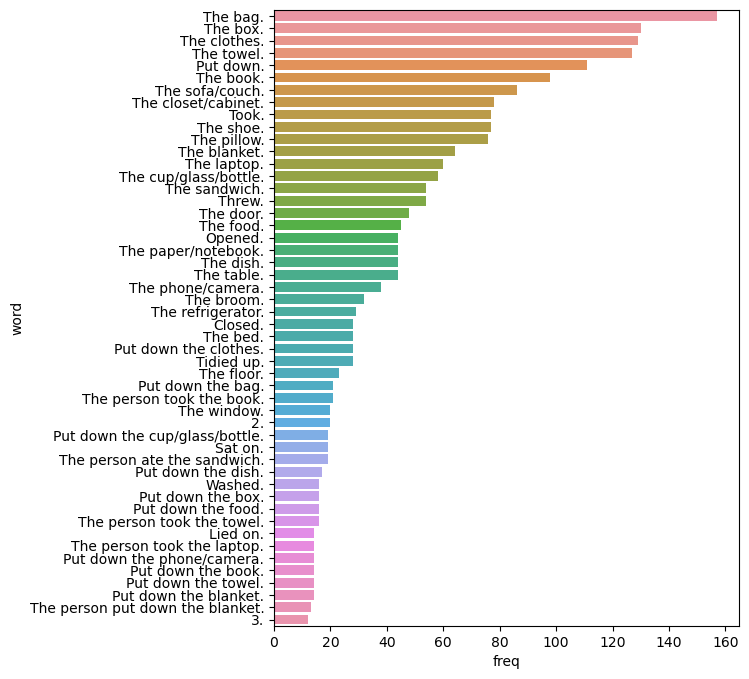

In [259]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [260]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


In [261]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(3910, 4)

In [262]:
def accuracy(eval_df, on_what='text'):
    # hits_num = (eval_df['pred_num'] == eval_df['num']).sum()
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [263]:
text_acc = accuracy(eval_df)
#num_acc = accuracy(eval_df, on_what='num')

#print(f"Numeric Accuracy: {num_acc:.2%}")
print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 29.80%


check if the equality with NA result in a false or is skipped

In [264]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 16.41%


In [265]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [266]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1527        29.21%  
Sequence            1754        29.48%  
Prediction           367        33.79%  
Feasibility          262        29.77%  
